In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np

from DataProcessing import DataProcessingPipeline
from DataCleaning import DataCleaningPipeline

Variables : ['Avg_Temp', 'humidity', 'wind_speed', 'Gd(i)']

In [55]:
# DataCleaningPipeline Parameters
path = ('data/data.csv')

# DataProcessingPipeline Parameters
variable = 'wind_speed'
latitude = 40.5112  # Latitude of the specific location
longitude = 16.3723  # Longitude of the specific location

In [56]:
# Data Cleaning Pipeline
pipeline_cleaning = DataCleaningPipeline(path)
df = pipeline_cleaning.run_pipeline()

# Data Processing Pipeline
pipeline_processing = DataProcessingPipeline(df, variable, latitude, longitude)
X_train, y_train, X_test, y_test = pipeline_processing.run_pipeline()

In [57]:
# Parameters
window_size = 365  # Number of samples in each training window
step_size = 180  # Number of samples to move the window by each iteration

# Total number of windows
total_windows = (len(X_train) - window_size) // step_size + 1

In [42]:
# ANN Model
def build_model(input_shape, variable):
    if variable == 'Avg_Temp' or variable =="humidity":
        model = Sequential([
            Dense(60, activation = LeakyReLU(), input_shape=(input_shape,),
                  kernel_regularizer=l2(0.01)),
            Dense(24)
        ])
    else:
        model = Sequential([
            Dense(60, activation='relu', input_shape=(input_shape,),
                  kernel_regularizer=l2(0.01)),
            Dense(24)
        ])
    model.compile(optimizer=Adam(), loss='mae')
    return model

In [6]:
# Rolling window
for window_start in range(0, total_windows * step_size, step_size):
    train_end = window_start + window_size
    if train_end > len(X_train):
        break

    # Split the dataset for this window
    X_train_window, y_train_window = X_train[window_start:train_end], y_train[window_start:train_end]

    # Build the model
    model = build_model(X_train_window.shape[1], variable)
    early_stopping = EarlyStopping(monitor='loss', patience=40, restore_best_weights=True, mode='min')
    # Fit the model
    if variable == 'wind_speed':
        model.fit(X_train_window, y_train_window, batch_size=10, epochs=3000, verbose=1, validation_split=0.1,
                  callbacks=[early_stopping])
    else:
        model.fit(X_train_window, y_train_window, batch_size=10, epochs=3000, verbose=1, validation_split=0.2,
                  callbacks=[early_stopping])
        
        
print(f"Training of {variable} model is finished.")
model.save(f'ANNs/{variable}')

Epoch 1/3000
33/33 [==============================] - 0s 2ms/step - loss: 6.9155 - val_loss: 2.6308
Epoch 2/3000
33/33 [==============================] - 0s 782us/step - loss: 1.8183 - val_loss: 1.6569
Epoch 3/3000
33/33 [==============================] - 0s 729us/step - loss: 1.3272 - val_loss: 1.2318
Epoch 4/3000
33/33 [==============================] - 0s 711us/step - loss: 1.2017 - val_loss: 1.1484
Epoch 5/3000
33/33 [==============================] - 0s 695us/step - loss: 1.1186 - val_loss: 1.1587
Epoch 6/3000
33/33 [==============================] - 0s 686us/step - loss: 1.0727 - val_loss: 1.1301
Epoch 7/3000
33/33 [==============================] - 0s 695us/step - loss: 1.0365 - val_loss: 1.1130
Epoch 8/3000
33/33 [==============================] - 0s 677us/step - loss: 1.0242 - val_loss: 1.0155
Epoch 9/3000
33/33 [==============================] - 0s 689us/step - loss: 0.9901 - val_loss: 1.0294
Epoch 10/3000
33/33 [==============================] - 0s 670us/step - loss: 0.9667 

INFO:tensorflow:Assets written to: ANNs/wind_speed/assets


In [58]:
model = tf.keras.models.load_model(f'ANNs/{variable}')

# Performance of the model with test dataset

In [59]:
prediction_test = model.predict(X_test)

12/12 [==============================] - 0s 421us/step


In [60]:
r2 = r2_score(y_test, prediction_test)
print(f'R-squared: {r2:.4f}')

R-squared: 0.6714


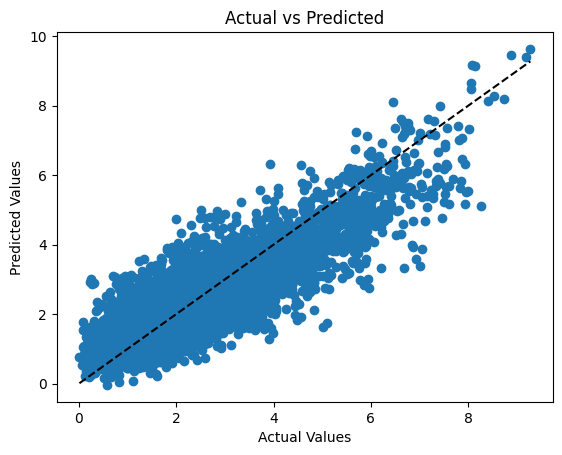

In [61]:
plt.scatter(y_test.reshape(-1), prediction_test.reshape(-1))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

In [62]:
daily_temp_pred = np.mean(prediction_test, axis=1)

stats_predicted = {
    'mean': daily_temp_pred.mean(),
    'std': daily_temp_pred.std(),
    'skewness': skew(daily_temp_pred)
}

stats_real = {
    'mean': y_test.mean(axis=1).mean(),
    'std': y_test.mean(axis=1).std(),
    'skewness': skew(y_test.mean(axis=1))
}

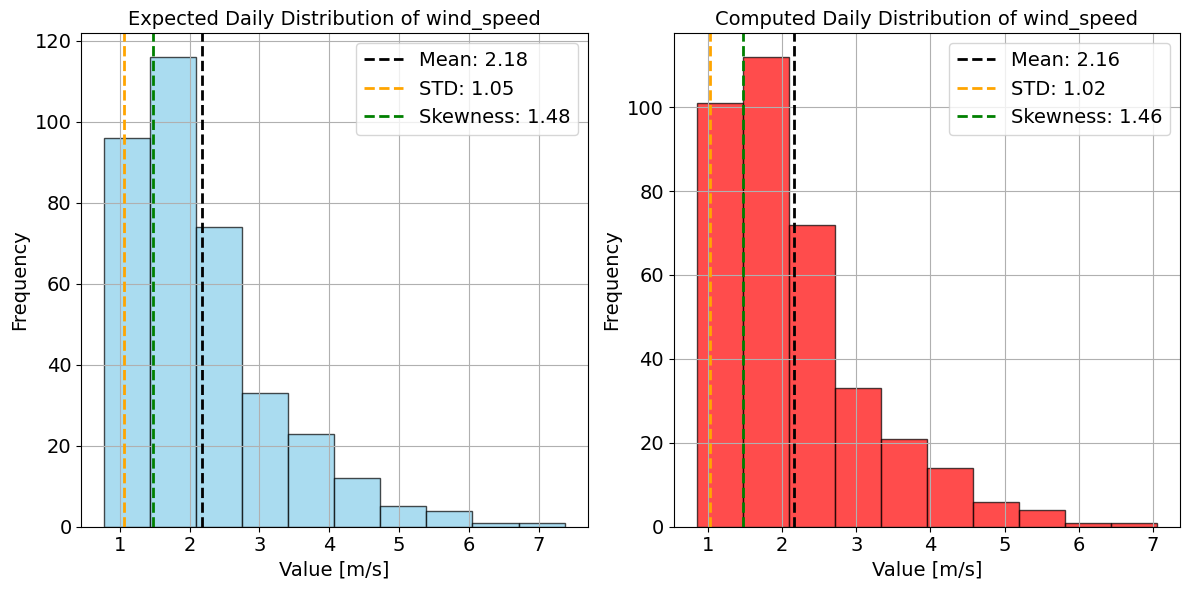

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Real Daily Means Plot
axes[0].hist(y_test.mean(axis=1), color='skyblue', edgecolor='black', alpha=0.7, bins=10)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].axvline(stats_real['mean'], color='black', linestyle='dashed', linewidth=2, label=f"Mean: {stats_real['mean']:.2f}")
axes[0].axvline(stats_real['std'], color='orange', linestyle='dashed', linewidth=2, label=f"STD: {stats_real['std']:.2f}")
# axes[0].axvline(stats_real['mean'] + stats_real['std'], color='orange', linestyle='dashed', linewidth=2, label=f"+1 STD: {stats_real['mean'] + stats_real['std']:.2f}")
axes[0].axvline(stats_real['skewness'], color='green', linestyle='dashed', linewidth=2, label=f"Skewness: {stats_real['skewness']:.2f}")
axes[0].set_title(f'Expected Daily Distribution of {variable}',fontsize=14)

if variable=="Gd(i)":
    axes[0].set_xlabel('Value [W/m2]',fontsize=14)
if variable=="wind_speed":
    axes[0].set_xlabel('Value [m/s]',fontsize=14)
if variable=="humidity":
    axes[0].set_xlabel('Value [%]',fontsize=14)
if variable=="Avg_Temp":
    axes[0].set_xlabel('Value [$\degree C$]',fontsize=14)

axes[0].set_ylabel('Frequency',fontsize=14)
axes[0].legend(fontsize=14)
axes[0].grid(True)

# Predicted Daily Means Plot
axes[1].hist(daily_temp_pred, color='red', edgecolor='black', alpha=0.7, bins=10)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].axvline(stats_predicted['mean'], color='black', linestyle='dashed', linewidth=2, label=f"Mean: {stats_predicted['mean']:.2f}")
axes[1].axvline(stats_predicted['std'], color='orange', linestyle='dashed', linewidth=2, label=f"STD: {stats_predicted['std']:.2f}")
# axes[1].axvline(stats_predicted['mean'] + stats_predicted['std'], color='orange', linestyle='dashed', linewidth=2, label=f"+1 STD: {stats_predicted['mean'] + stats_predicted['std']:.2f}")
axes[1].axvline(stats_predicted['skewness'], color='green', linestyle='dashed', linewidth=2, label=f"Skewness: {stats_predicted['skewness']:.2f}")
axes[1].set_title(f'Computed Daily Distribution of {variable}',fontsize=14)

if variable=="Gd(i)":
    axes[1].set_xlabel('Value [W/m2]',fontsize=14)
if variable=="wind_speed":
    axes[1].set_xlabel('Value [m/s]',fontsize=14)
if variable=="humidity":
    axes[1].set_xlabel('Value [%]',fontsize=14)
if variable=="Avg_Temp":
    axes[1].set_xlabel('Value [$\degree C$]',fontsize=14)

axes[1].set_ylabel('Frequency',fontsize=14)
axes[1].legend(fontsize=14)
axes[1].grid(True)



plt.tight_layout()
plt.savefig("/Users/roozbeh/Downloads/temp_stat2028.pdf", format='pdf',bbox_inches="tight")
plt.show()
